In [87]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/cv.allset_train.iforest.yaml/'))
assert os.path.isdir(maindir)

evalreports = os.path.join(maindir, 'evalreports')
assert os.path.isdir(evalreports)

# create evaluations all:
# import sod.core.evaluation as sod_core_eval
# importlib.reload(sod_core_eval)

# print('Creating evaluations all (html)')
# sod_core_eval.aggeval(evalreports, format='html')

# print('Creating evaluations all (hdf)')
# sod_core_eval.aggeval(evalreports, format='hdf')

# path = os.path.join(evalreports, 'evaluations.all.hdf')

# dfr = pd.read_hdf(path)
# print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
# print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

def select(df, classes):
    sel = None
    for k, v in classes.items():
        if sel is None:
            sel = v(df)
        else:
            sel |= v(df)
    return df[sel]


In [100]:
names = [
    'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=200&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=200&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new',
    'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new',
]

clfs = {}
preds = {}
for name in names:
    modelpath = os.path.join(maindir, 'models', name + '.model')
    predictionspath = os.path.join(maindir, 'predictions', name + '.hdf')
    if not os.path.isfile(predictionspath):
        print(' Not found: %s' % os.path.basename(predictionspath))
        continue
    print('Loading: %s' % name)
    clfs[name] = load(os.path.join(maindir, 'models', modelpath))
    preds[name] = pd.read_hdf(predictionspath)

Loading: IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=200&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=200&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new
Loading: IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new


In [101]:
print('Relabelling Me unknown and Me suspicious outlier')
# adding now the two best overall:
print('\nSetting categorical data and score samples')

me_susp_outliers_selector = sod_core_dataset.allset_train.class_selector[sod_core_dataset.allset_train.classnames[-2]]
me_unknown_selector = sod_core_dataset.allset_train.class_selector[sod_core_dataset.allset_train.classnames[-1]]

for name, pred_df in preds.items():
    pred_df.loc[(me_susp_outliers_selector(pred_df) | me_unknown_selector(pred_df)), 'outlier'] = False
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    pred_df['score_samples'] = -(pred_df['decision_function'] + clfs[name].offset_)
    preds[name] = pred_df

print('\nDone. Predictions dataframes columns:')
print(list(preds.values())[0].columns.tolist())  # one is sufficient
print()

Relabelling Me unknown and Me suspicious outlier

Setting categorical data and score samples

Done. Predictions dataframes columns:
['allset_train.id', 'correctly_predicted', 'log_loss', 'decision_function', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples']



In [102]:
# TEMP: set outliers after infspection. UNCOMMENT LINE BELOW TO SET OUTLIERS OF UNLABELLED ME
# AUTOMATICALLY

# from collections import defaultdict


# print('\nSetting outliers manually')
# classnames = sod_core_dataset.allset_train.classnames[1:]
# classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

# outl_staids = defaultdict(int)
# print('Getting stations with all outliers')
# for name, pred_df in preds.items():
#     for station_id, dfr in pred_df[pred_df.dataset_id == 2].groupby(['station_id']):
#         if (dfr.score_samples > 0.5).all() or dfr.score_samples.median() >= 0.8:
#             outl_staids[station_id] += 1

# # take only the staids common to all pred_df:
# outl_staids = {k :v for k, v in outl_staids.items() if v == len(preds)}
# print('Station ids whose segments have to be set as outliers:')
# print(list(outl_staids.keys()))

# for name, pred_df in preds.items():
#     for staid in outl_staids.keys():
#         pred_df.loc[(pred_df.dataset_id==2) & (pred_df.station_id == staid), 'outlier'] = True

# print('\nDone. Predictions dataframes columns:')
# print(list(preds.values())[0].columns.tolist())  # one is sufficient
# print()

print('Setting station ids with outliers')
staids = [640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 656, 657, 658, 659, 660, 661, 662, 663, 712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 725, 726, 727, 728, 729, 730, 1070, 1071, 1096, 1342, 1412, 1414, 1421, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 1980, 1990, 1993, 1997, 2410, 2772, 2860, 2861, 2863, 2864, 2904, 3541, 3714, 3715, 3716, 3717, 3727, 3728, 3729, 3730, 3731]
for name, pred_df in preds.items():
    for staid in staids:
        pred_df.loc[(pred_df.dataset_id==2) & (pred_df.station_id == staid), 'outlier'] = True


Setting outliers manually
Getting stations with all outliers
Station ids whose segments have to be set as outliers:
[640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 656, 657, 658, 659, 660, 661, 662, 663, 712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 725, 726, 727, 728, 729, 730, 1070, 1071, 1096, 1342, 1412, 1414, 1421, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 1980, 1990, 1993, 1997, 2410, 2772, 2860, 2861, 2863, 2864, 2904, 3541, 3714, 3715, 3716, 3717, 3727, 3728, 3729, 3730, 3731]

Done. Predictions dataframes columns:
['allset_train.id', 'correctly_predicted', 'log_loss', 'decision_function', 'dataset_id', 'subclass', 'window_type', 'channel_code', 'location_code', 'station_id', 'outlier', 'cha_id', 'score_samples']




ROC curves (only using classes: ('outl. (wrong inv)', 'unlabeled (Me suspicious outl.)', 'unlabeled (Me unknown)'))


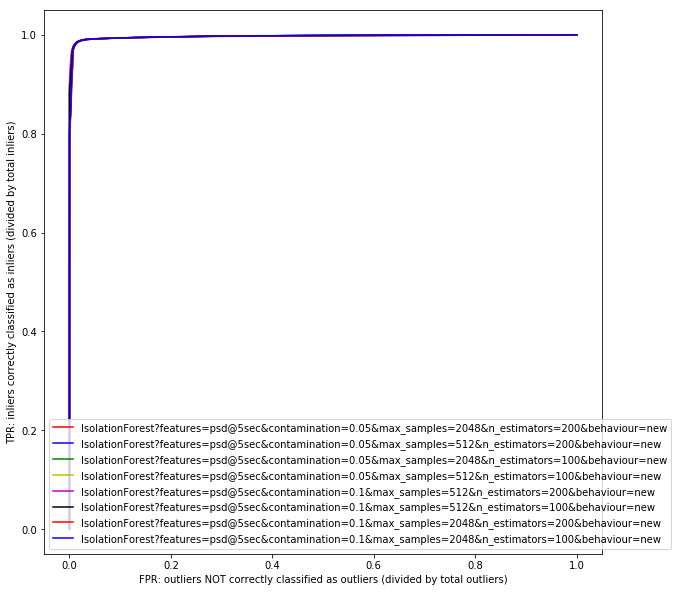

In [103]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
from sklearn.metrics import roc_curve

from itertools import cycle
import numpy as np

import numpy as np
from sklearn import metrics

# >>> y = np.array([1, 1, 2, 2])
# >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
# >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
# >>> metrics.auc(fpr, tpr)
# 0.75




# select all classes except inliers (used for training):
classnames = sod_core_dataset.allset_train.classnames[1:]
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}


%matplotlib inline

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# take all Me unknown and Me suspicious outliers, groupby station. If median score > 0.8 OR all scores > 0.5,
# mark them as outlier
            
# roc curve classes ignore the Me suspicious outliers (use only more "sure" classes):
rc_classnames = sod_core_dataset.allset_train.classnames[1:]
# TEMP MODIFICATION: use only last two classes (Me unknown and Me suspicious)
# rc_classnames = sod_core_dataset.allset_train.classnames[-2], sod_core_dataset.allset_train.classnames[-1]
rc_classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in rc_classnames}

# from collections import defaultdict
# aucs = defaultdict(list)

# outlier_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# for name, prd_df in preds.items():
#     print('Calculating roc auc for different thresholds for %s' % name)
#     roc_df = select(prd_df, rc_classes)
#     roc_df = roc_df[['outlier', 'score_samples']].copy()
#     # classes 'unlabeled.maybe.outlier' (rc_classnames[0]) is labelled as outlier, set all to False 
#     # roc_df.outlier = False
#     # print('%s outlier out of %d' % (roc_df.outlier.sum(), len(roc_df)))
#     for outlier_threshold in outlier_thresholds:
#         # print('%d' % outlier_threshold)
#         _roc_df = roc_df.copy()
#         _roc_df.loc[_roc_df.score_samples >= outlier_threshold, 'outlier'] = True
#         print('%d inliers, %d outliers' % ((~_roc_df.outlier).sum(), _roc_df.outlier.sum()  ))
#         fpr, tpr, thresholds = roc_curve(_roc_df['outlier'] * 1.0, _roc_df['score_samples'])
#         aucs[name].append(metrics.auc(fpr, tpr))
#     print(aucs[name])

        
# with plotparams({'figure.figsize': (10, 10)}):
#     for name, values in aucs.items():
#         plt.plot(outlier_thresholds, values, label=name)

#     print('\nROC curves (only using classes: %s)' % str(rc_classnames))
#     plt.ylabel('TPR: inliers correctly classified as inliers (divided by total inliers)')
#     plt.xlabel('FPR: outliers NOT correctly classified as outliers (divided by total outliers)')
#     plt.legend()
#     plt.show()



aucs = []
colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        
        k = 'score_samples'
#        print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes).copy()
        assert roc_df.outlier.any() and (~roc_df.outlier.all())
        roc_df.loc[roc_df.score_samples >= 0.75, 'outlier'] = True
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # print([thresholds[np.argwhere(tpr>=0.9)[-1][0]], thresholds[np.argwhere(fpr<=0.1)[-1][0]]])
        aucs.append([name, metrics.auc(fpr, tpr)])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('TPR: inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('FPR: outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
#     plt.show()


In [104]:
import pandas as pd
df = pd.DataFrame(aucs, columns=['name', 'auc'])
dfsorted = df.sort_values(by=['auc'], ascending=False)
# with pd.set_option('display.max_colwidth',1000):
with pd.option_context('display.max_colwidth', 1000):
    print(dfsorted.to_string(line_width=1000, index=False))

name       auc
  IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=200&behaviour=new  0.997508
  IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new  0.997295
 IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new  0.997127
 IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new  0.997060
IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new  0.996921
 IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new  0.996900
IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=200&behaviour=new  0.996828
 IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new  0.996569


In [11]:
from sod.core import pdconcat

spreds = {}  # station predictions dataframes

groupcols = ['cha_id', 'dataset_id', 'station_id', 'location_code']
added_cols = ['subclass', 'outlier', 'score_samples', 'decision_function', 'num segs']

print('Creating stations prediction dataframes, PLEASE WAIT')
# print(groupcols)

for name, prd_df in preds.items():
    prd_df = select(prd_df, classes)
    data = []
    for colz_vals, df in prd_df.groupby(groupcols):
        if df.empty:
            continue
        row = list(colz_vals)
        zum = df['outlier'].sum()
        assert zum == 0 or zum == len(df)
        assert len(pd.unique(df['subclass'])) == 1
        row += [df.iloc[0]['subclass'], df.iloc[0]['outlier'],
                df.score_samples.median(), df.decision_function.median(), len(df)]
        data.append(row)
    spreds[name] = pd.DataFrame(data, columns = groupcols + added_cols)
    # spreds[name] = pdconcat(data)
print('Done')

Creating stations prediction dataframes
['cha_id', 'dataset_id', 'station_id', 'location_code']
Done



CONFUSION MATRICES AT STATION LEVEL


ROC curves (only using classes: ('outl. (wrong inv)', 'unlabeled (Me unknown)'))


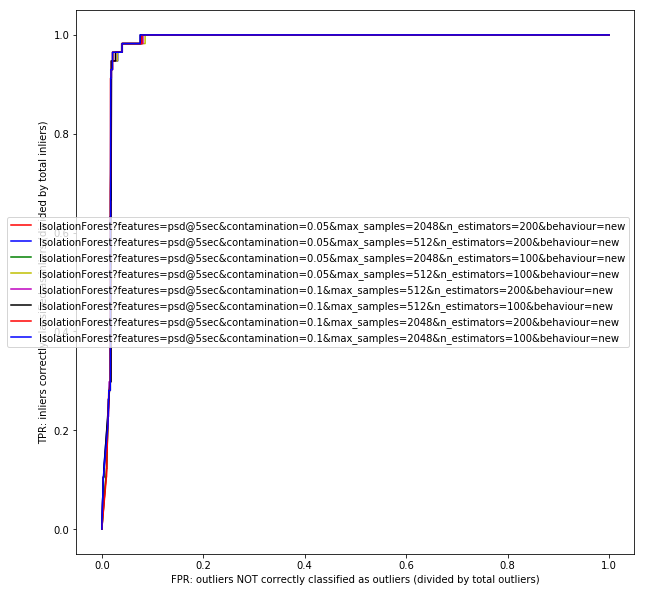

In [12]:
# from sklearn.metrics.log_loss
print('\nCONFUSION MATRICES AT STATION LEVEL\n')
saucs = []

colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        
        k = 'score_samples'
#        print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes)
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # print([thresholds[np.argwhere(tpr>=0.9)[-1][0]], thresholds[np.argwhere(fpr<=0.1)[-1][0]]])
        saucs.append([name, metrics.auc(fpr, tpr)])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('TPR: inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('FPR: outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [13]:
sdf = pd.DataFrame(saucs, columns=['name', 'auc'])
sdfsorted = sdf.sort_values(by=['auc'], ascending=False)
# with pd.set_option('display.max_colwidth',1000):
with pd.option_context('display.max_colwidth', 1000):
    print(sdfsorted.to_string(line_width=1000, index=False))

name       auc
 IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=100&behaviour=new  0.984312
 IsolationForest?features=psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new  0.983879
IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=200&behaviour=new  0.983695
IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new  0.983683
  IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new  0.983552
  IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=200&behaviour=new  0.983450
 IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new  0.983424
 IsolationForest?features=psd@5sec&contamination=0.05&max_samples=512&n_estimators=100&behaviour=new  0.983205


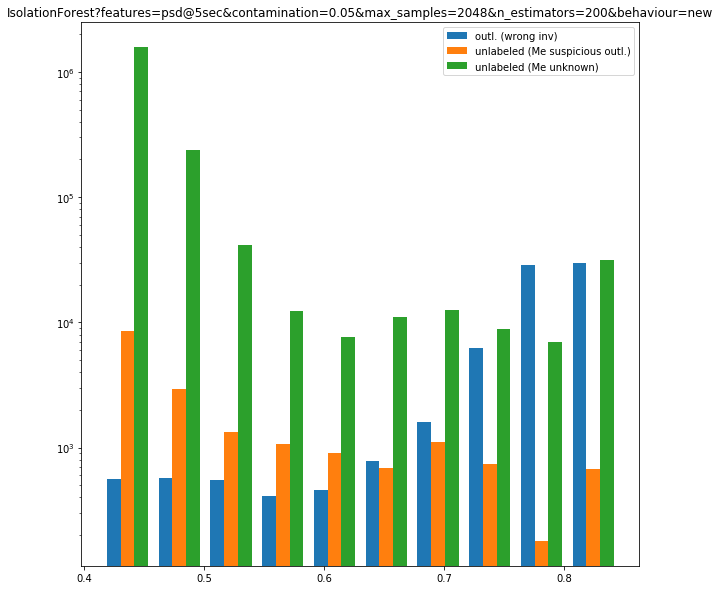

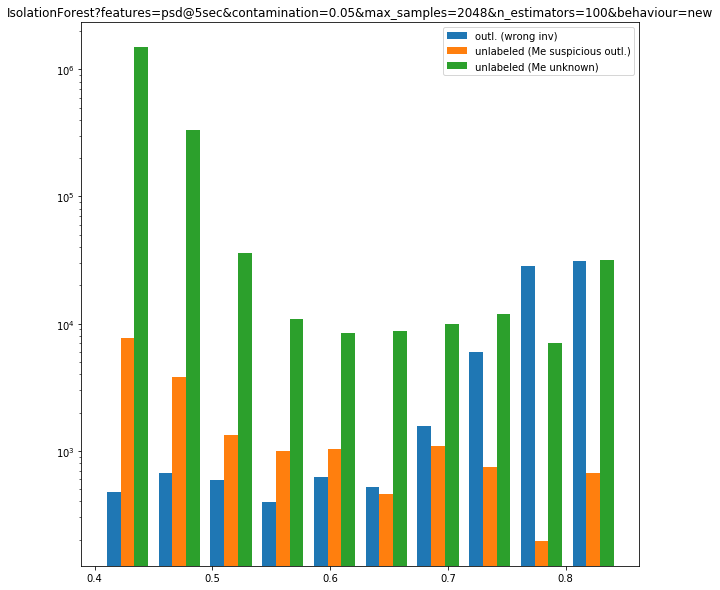

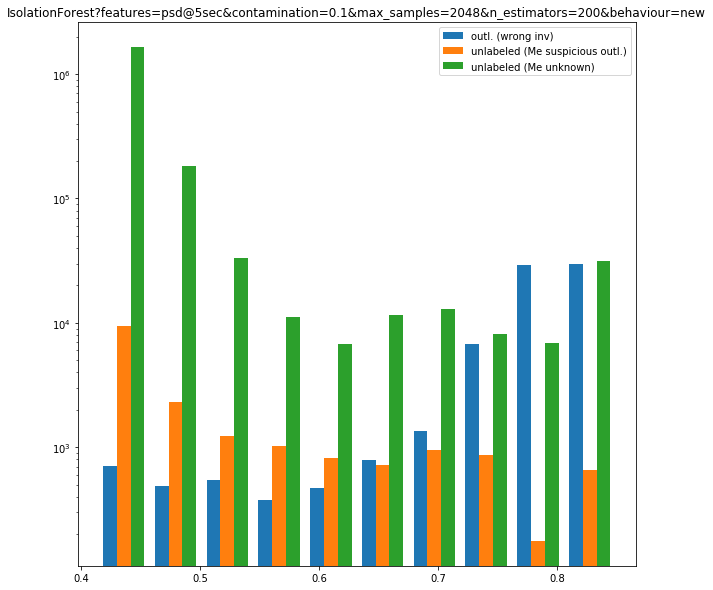

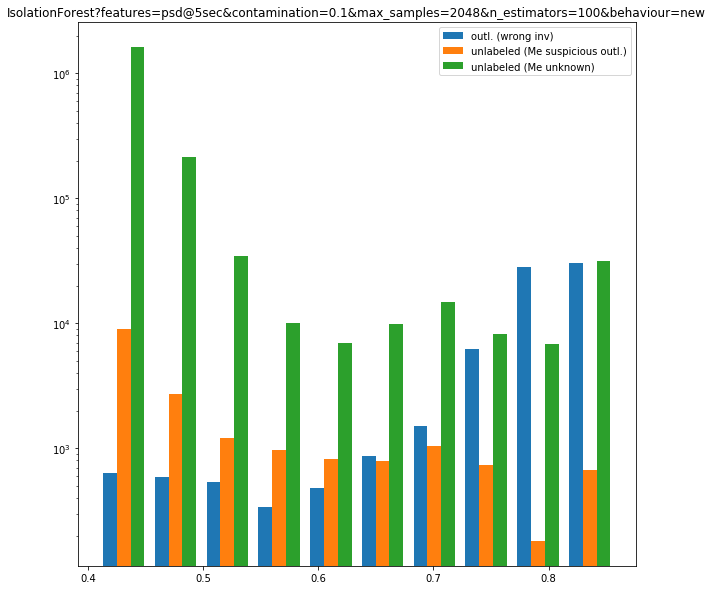

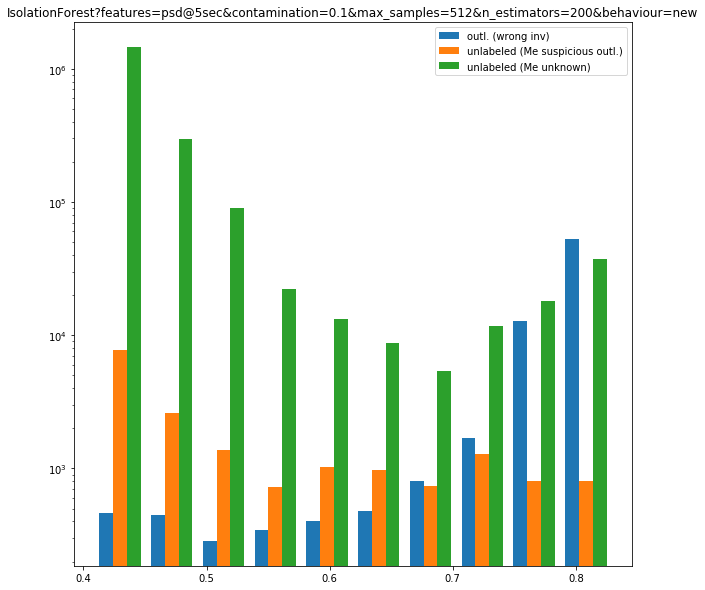

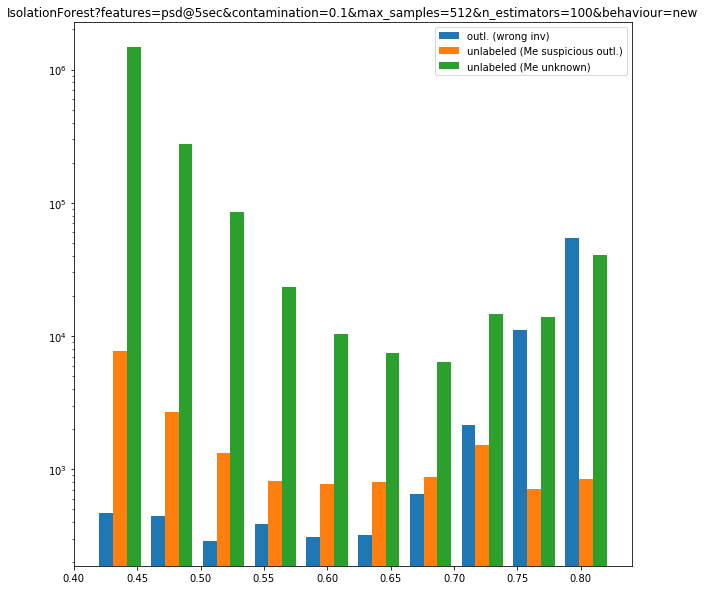

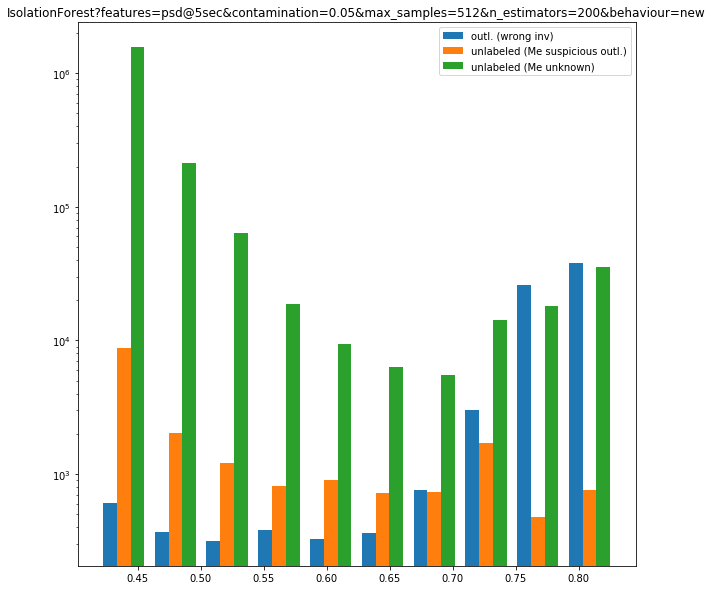

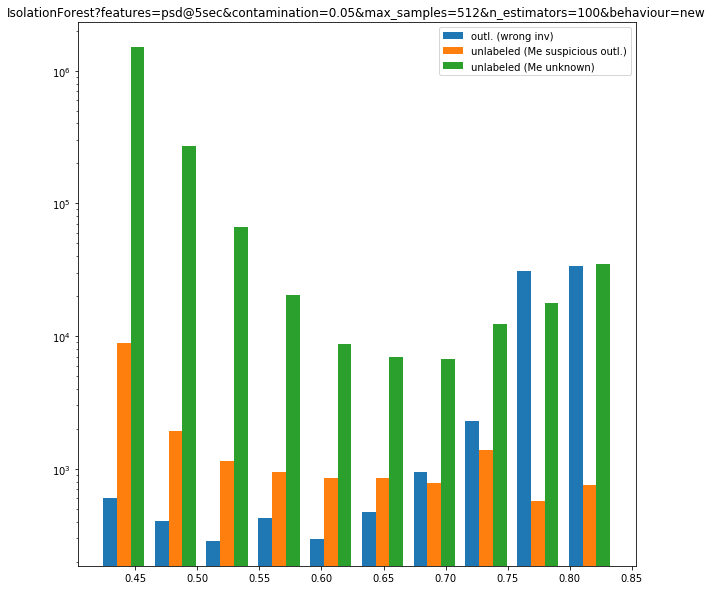

In [16]:
classnames = sod_core_dataset.allset_train.classnames[1:]  # ignore the 'ok' label cause it is used for fitting
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name in dfsorted['name'][:10]:
        prd_df = preds[name]
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()
#         prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#         print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#         prd_df_msclf.drop(['decision_function'], 1, inplace=True)
#         print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))

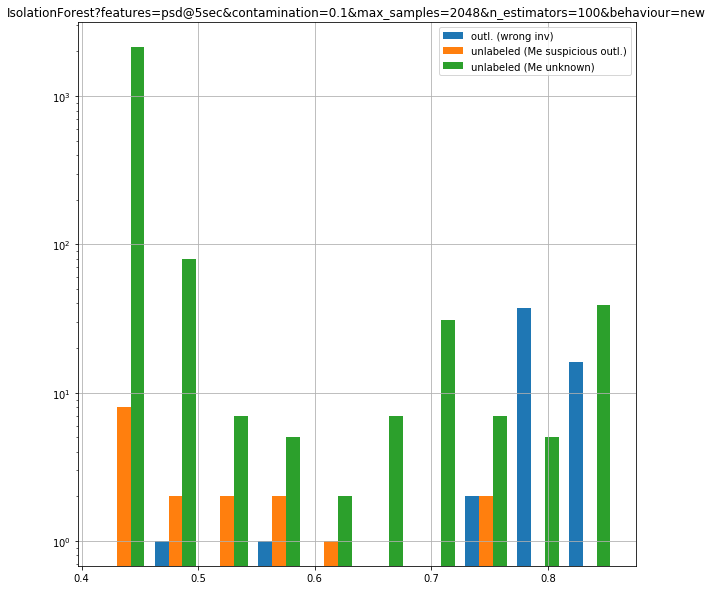

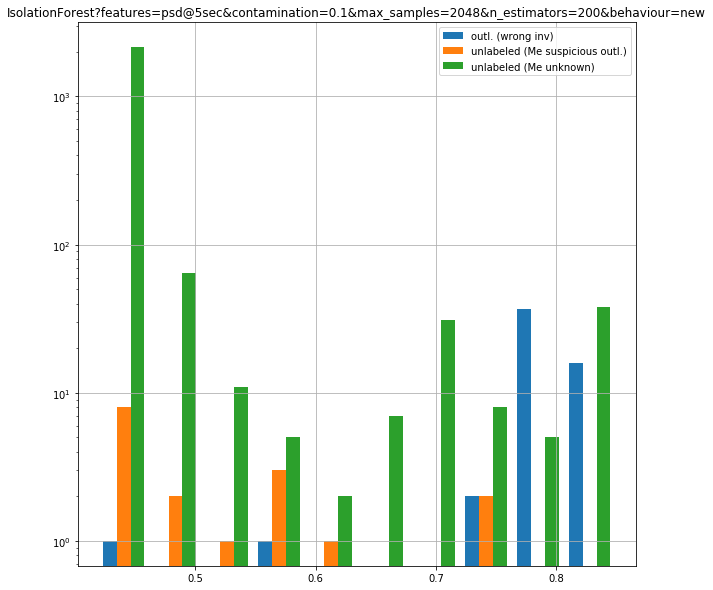

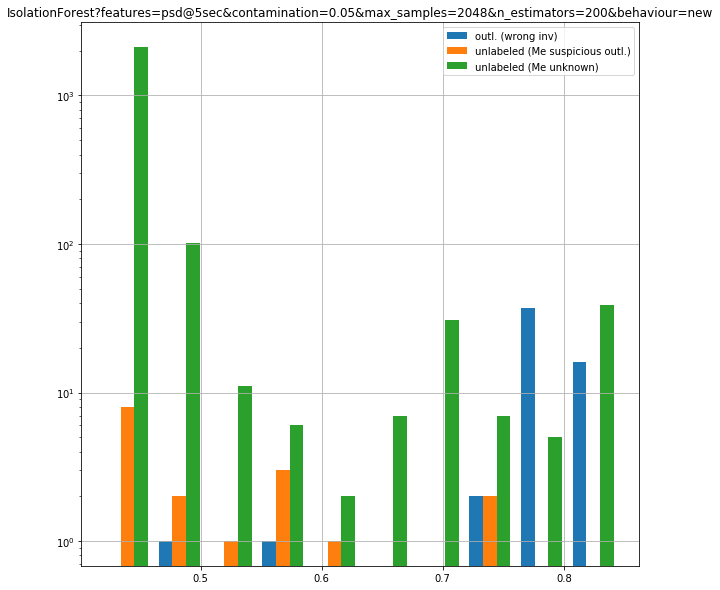

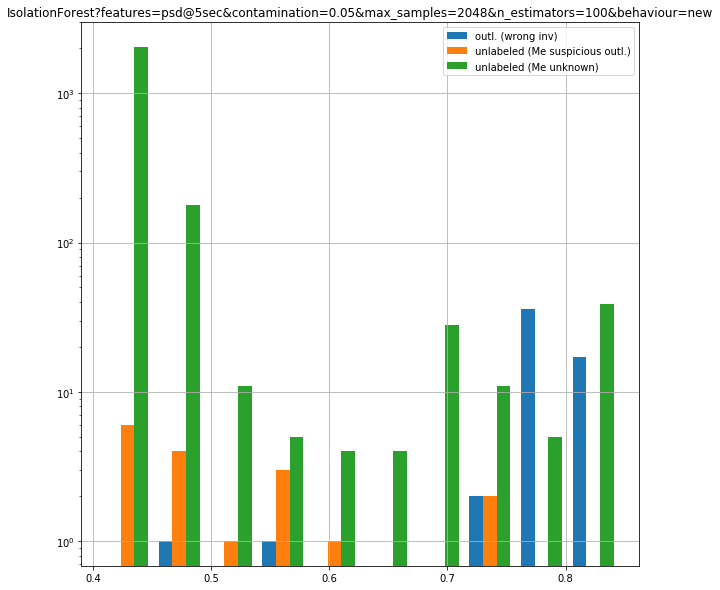

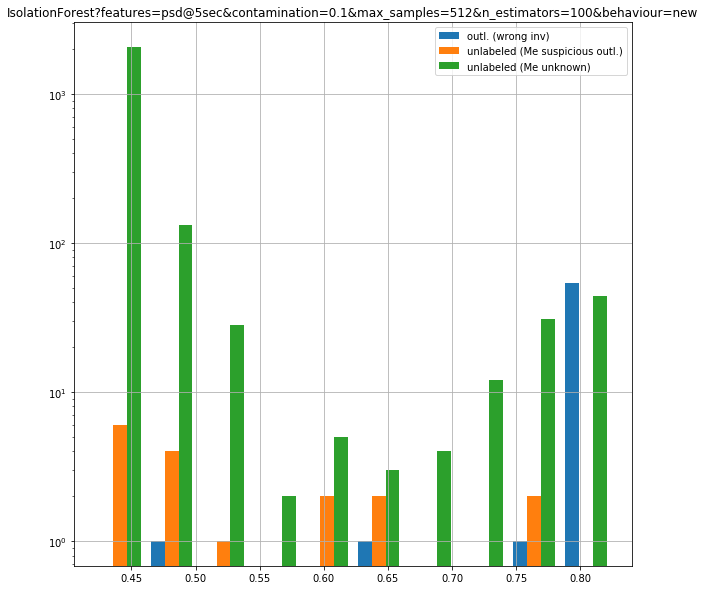

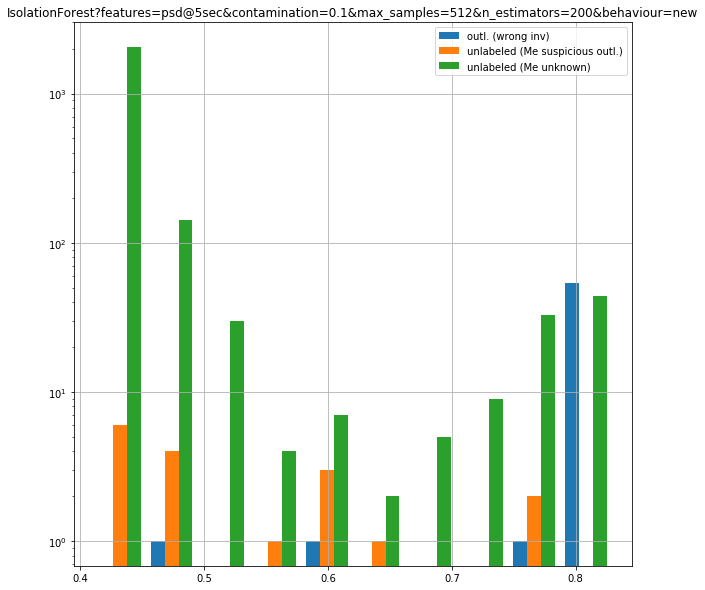

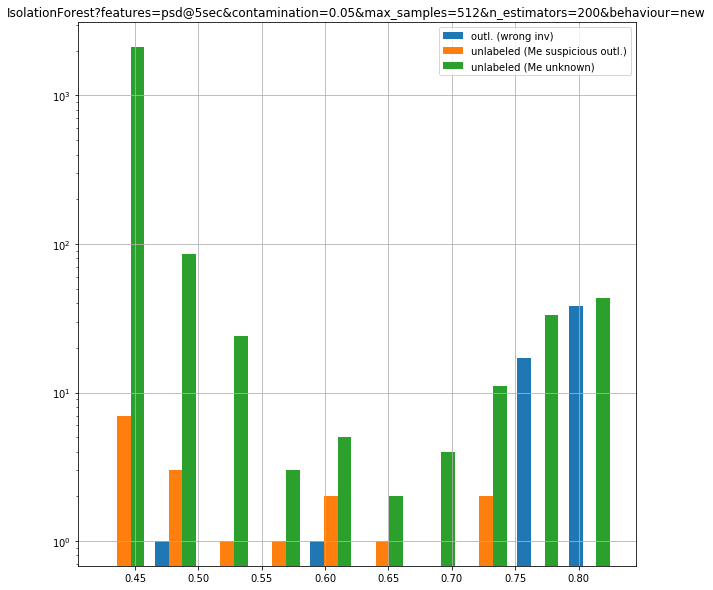

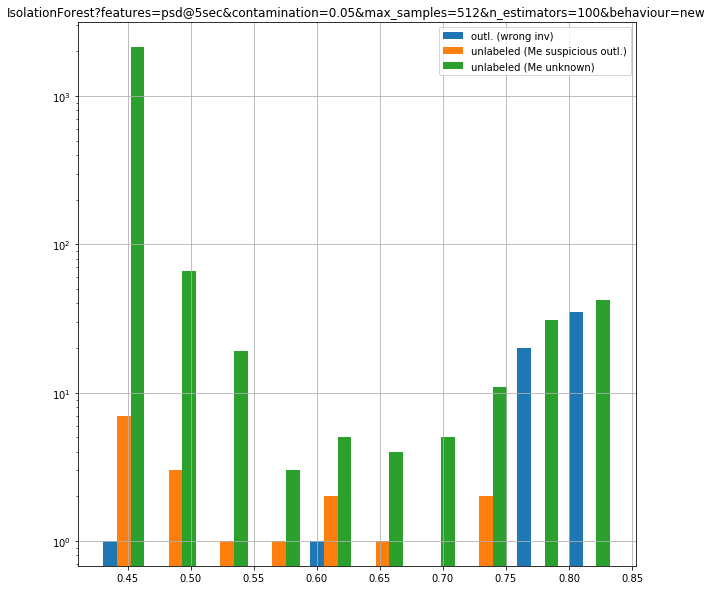

In [17]:
classnames = sod_core_dataset.allset_train.classnames[1:]  # ignore the 'ok' label cause it is used for fitting
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name in sdfsorted['name'][:10]:
        prd_df = spreds[name]
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.grid(True)
        plt.show()
#         prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#         print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#         prd_df_msclf.drop(['decision_function'], 1, inplace=True)
#         print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))

In [21]:
# READING THE TRAIN DATAFRAME TO COMPARE PERFORMANCES:
import time
from sod.core.evaluation import _predict
from sod.core.dataset import allset_train
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}

alldfr = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)
print(sod_core_dataset.dfinfo(alldfr))


ok (1451765 instances)
                         Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -3076.526611 -121.268117    -18.616519  614002         0       8378
psd@0.1sec      -3076.526611 -123.085388    -18.540183       0     14518      14518
psd@0.2sec      -3076.526611 -124.808643    -18.394193       1     14518      14518
psd@0.5sec      -3076.526611 -126.766839    -17.799973       4     14518      14518
psd@1sec        -3076.526611 -124.398356    -17.364621      10     14518      14518
psd@2sec        -3076.526611 -121.330894    -14.675753      21     14518      14518
psd@3sec        -3076.526611 -121.021820     -7.249915      54     14518      14518
psd@5sec        -3076.526611 -122.757093      7.845090      56     14518      14518
psd@9sec        -3076.526611 -131.116604     19.164349   27289     14245      14245
amplitude_ratio     0.000000    0.001165     36.623112       0     14481      11927
magnitude           0.900000    4.400000      8.9000

Creating randomly sampled datasets to test
['psd@5sec']
['psd@5sec']
['psd@5sec']
['psd@5sec']
['psd@5sec']
['psd@5sec']
['psd@5sec']
['psd@5sec']

Estimating performances

Plotting Performances


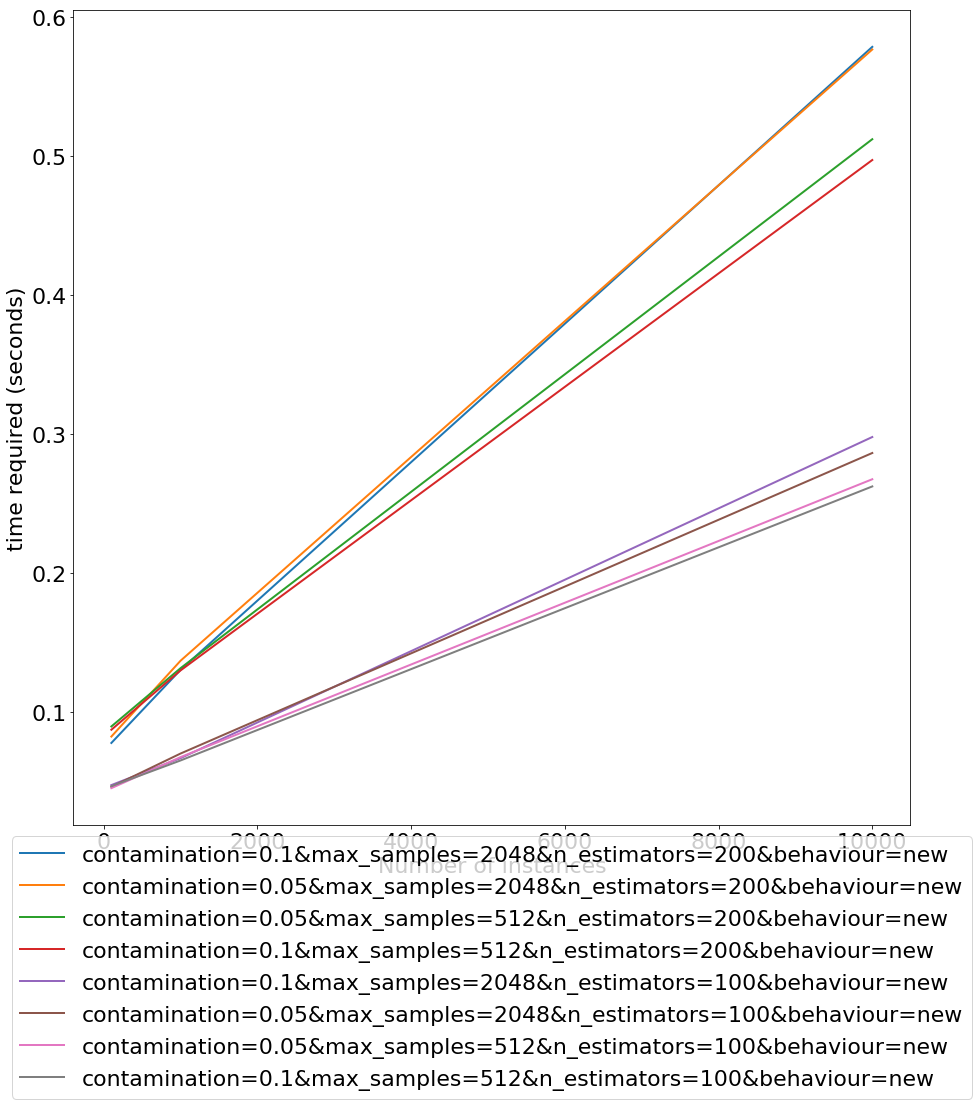

In [41]:
# TESTING PERFORMANCES. DO NOT RUN THIS CODE IN YOUR COMPUTER, IT RELIES ON FILES WHICH WERE TO BIG TO BE
# COMMITTED IN THE GITHUB REPOSITORY

import time
from sod.core.evaluation import _predict
from sod.core.dataset import allset_train
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}

# defining the number of instances to take for each test:
numinst = (100, 1000, 10000)  # , 100000)

print('Creating randomly sampled datasets to test')
datasets = {}  # mapping (features, numpts) to a allset_train subset
for name, clf in clfs.items():
    feats = name[name.find('features=') + len('features='):].split('&')[0].split(',')
    print(feats)
    for ninsts in numinst:
        key_ = (tuple(feats), ninsts)
        if key_ not in datasets:
            datasets[key_] = alldfr.dropna(subset=feats).sample(ninsts)[feats]
            
plotdata_ = []  # a list of [[times], label_string] elements
print('\nEstimating performances')
for name, clf in clfs.items():
    feats = name[name.find('features=') + len('features='):].split('&')[0].split(',')
    plotdata = []
    for ninsts in numinst:
        ints = np.random.randint(0, len(_alldfr), test)
        # dataf = dataframe.iloc[ints]
        test_df = datasets[(tuple(feats), ninsts)]
        t = time.time()
        #print(dataf[feats])
        # raise
        prd = _predict(clf, test_df)
        t = time.time() - t
        plotdata.append(t)
    label_noclfname_nofeats = name[name.find('features='):]
    label_noclfname_nofeats = label_noclfname_nofeats[label_noclfname_nofeats.find('&')+1:]
    plotdata_.append([plotdata, label_noclfname_nofeats]) 

plotdata_.sort(key=lambda val: val[0][-1], reverse=True)

with plotparams({'figure.figsize': (15, 15), 'font.size': 22}):

    print('\nPlotting Performances')

    for plotdata in plotdata_:
        plt.plot(numinst, plotdata[0], label=plotdata[1], linewidth=2)
    plt.xlabel('Number of instances')
    plt.ylabel('time required (seconds)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.))
plt.show()



In [ ]:
# TESTING PERFORMANCES. DO NOT RUN THIS CODE IN YOUR COMPUTER, IT RELIES ON FILES WHICH WERE TO BIG TO BE
# COMMITTED IN THE GITHUB REPOSITORY

import time
from sod.core.evaluation import _predict
from sod.core.dataset import allset_train
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}

clazzf = {}  # mapping 

with plotparams({'figure.figsize': (15, 15), 'font.size': 22}):

    print('\nPerformances')

    numinst = (100, 1000, 10000)  # , 100000)
    # dfs = {_: alldfr.iloc[np.random.randint(0, len(dataframe), _)].dropna() for _ in numinst}
    print('\nEstimating performances')
    for name, clf in clfs.items():
        feats = name[name.find('features=') + len('features='):].split('&')[0].split(',')
        _alldfr = alldfr.dropna(subset=feats)
        print(feats)
        plotdata = []
        for ninsts in numinst:
            ints = np.random.randint(0, len(_alldfr), test)
            # dataf = dataframe.iloc[ints]
            test_df = _alldfr.sample(ninsts)[feats]
            t = time.time()
            #print(dataf[feats])
            # raise
            prd = _predict(clf, test_df)
            t = time.time() - t
            plotdata.append(t)
        plt.plot(numinst, plotdata, label=name)
    plt.xlabel('Number of instances')
    plt.ylabel('time required (seconds)')
    plt.legend()
plt.show()

